ZENODO HARVESTER & ANALYTICS DASHBOARD
Options:
1. Harvest fresh data from Zenodo API
2. Run analytics using saved data file
3. Harvest fresh data (force refresh)
4. Exit



Enter your choice (1-4):  1


Starting Zenodo harvest...
🌐 Harvesting data for nfdi4biodiversity...
  Harvesting nfdi4biodiversity (page 1)...
  Page 1: 100 records
  Page 2: 100 records
  Page 3: 100 records
  Page 4: 100 records
  Page 5: 100 records
  Page 6: 100 records
  Page 7: 100 records
  Page 8: 100 records
  Request error on page 9: 504 Server Error: Gateway Time-out for url: https://zenodo.org/api/records?communities=nfdi4biodiversity&size=100&page=9&sort=mostrecent&all_versions=True
✅ Found 800 records for nfdi4biodiversity
🌐 Harvesting data for hefdi...
  Harvesting hefdi (page 1)...
  Page 1: 100 records
  Page 2: 100 records
  Page 3: 53 records
✅ Found 253 records for hefdi
✅ Data saved to zenodo_data.json (1053 records)
📄 Generated report: nfdi4biodiversity_report.csv
📄 Generated affiliation report: nfdi4biodiversity_affiliations.csv
📄 Generated report: hefdi_report.csv
📄 Generated affiliation report: hefdi_affiliations.csv
✅ Harvest completed! Processed 1053 total records.
💾 Data saved to: zenodo

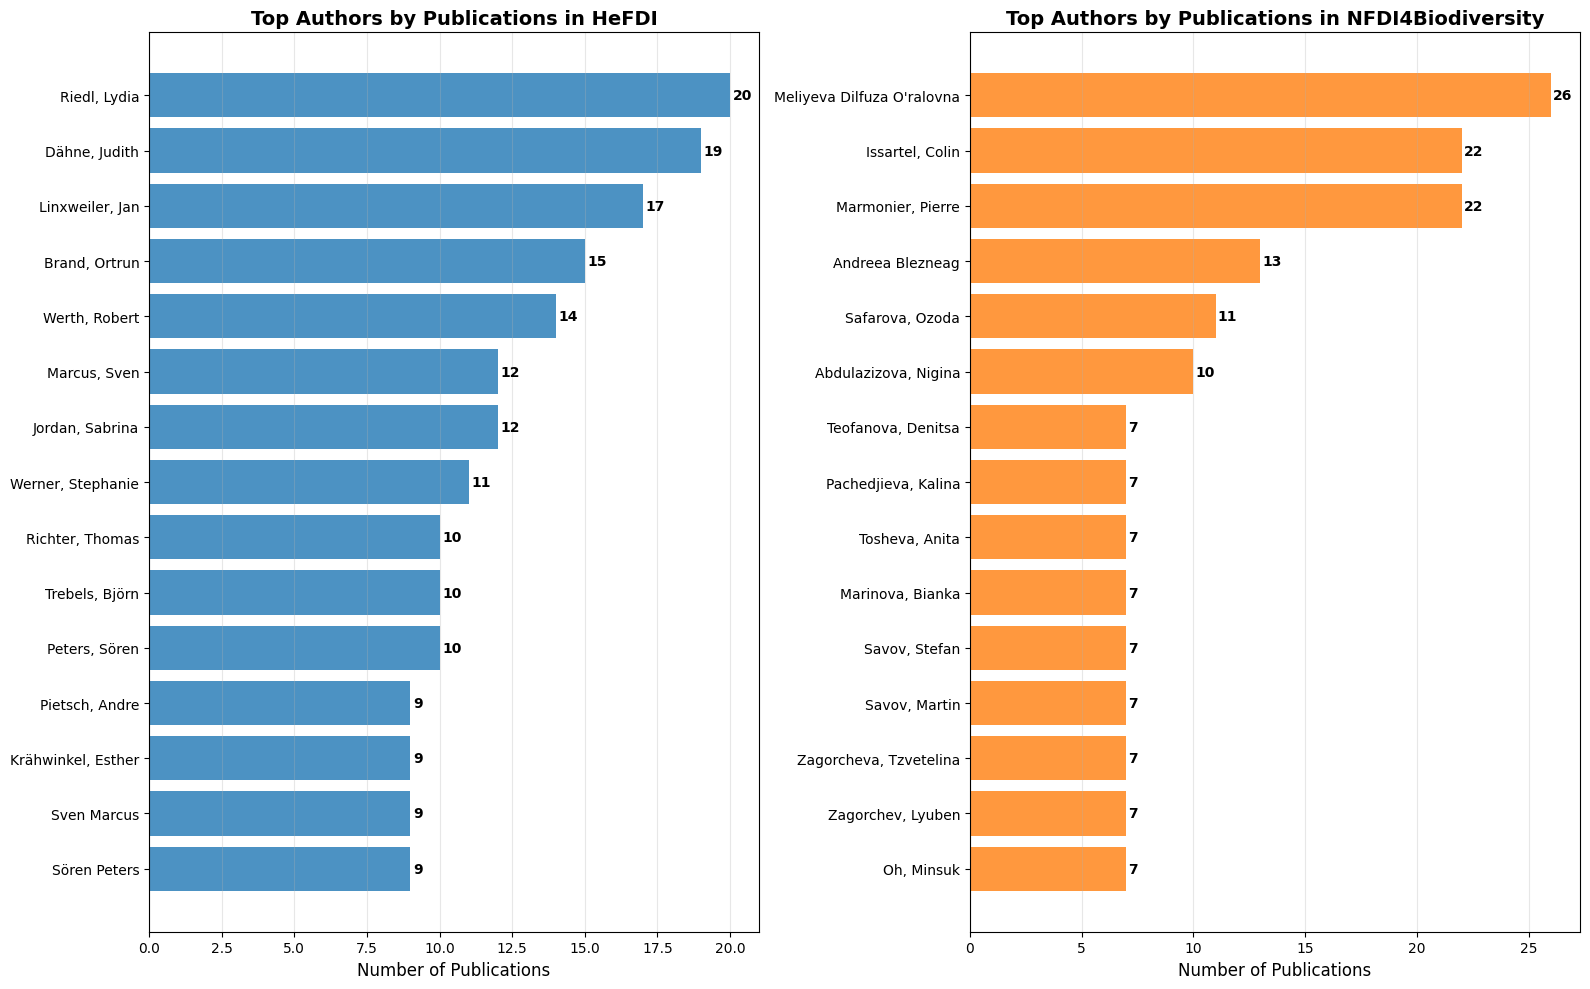

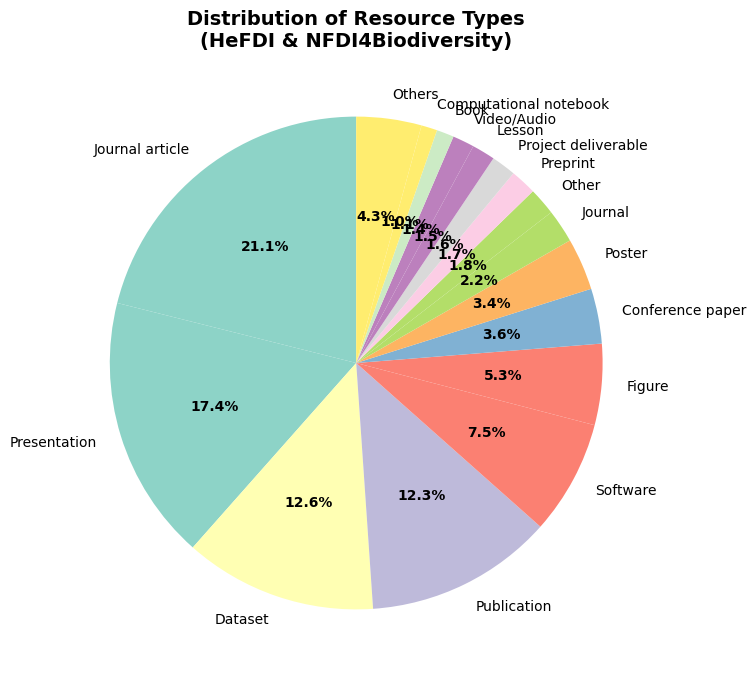

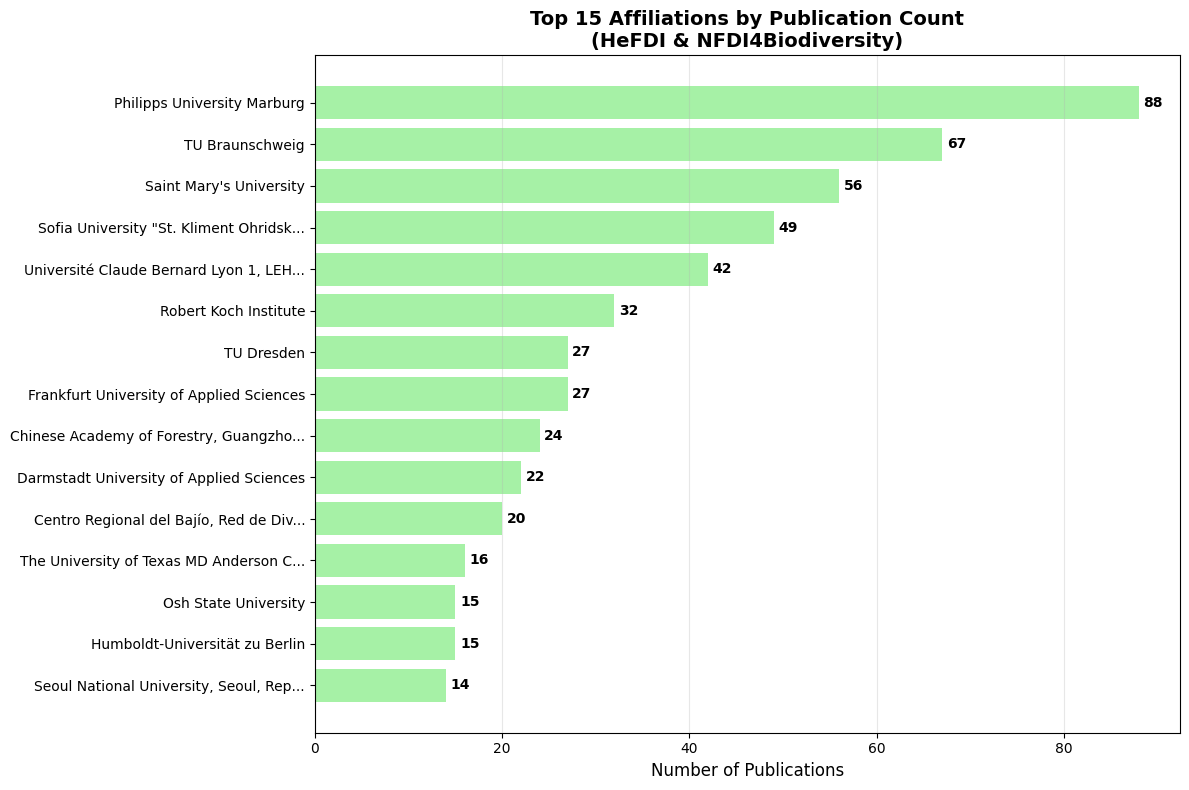

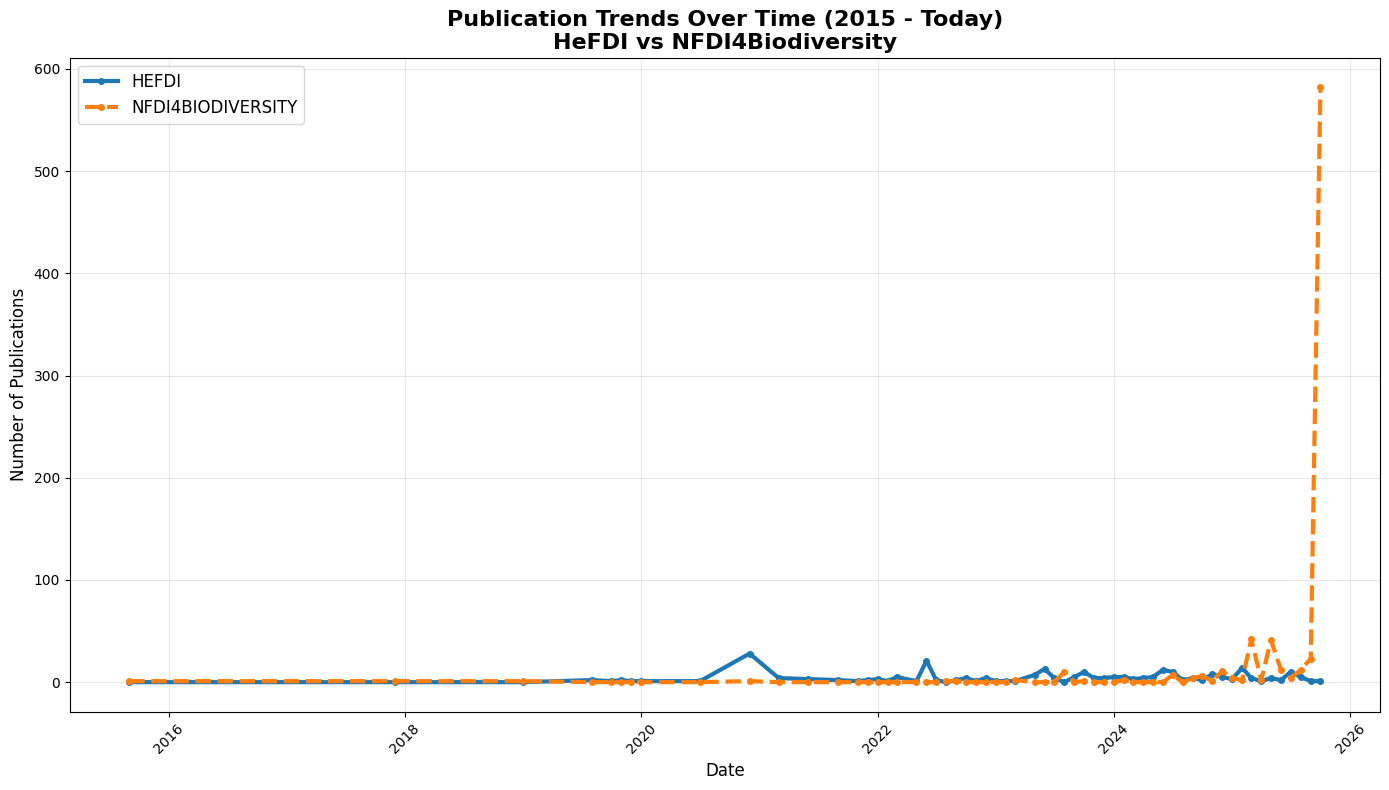

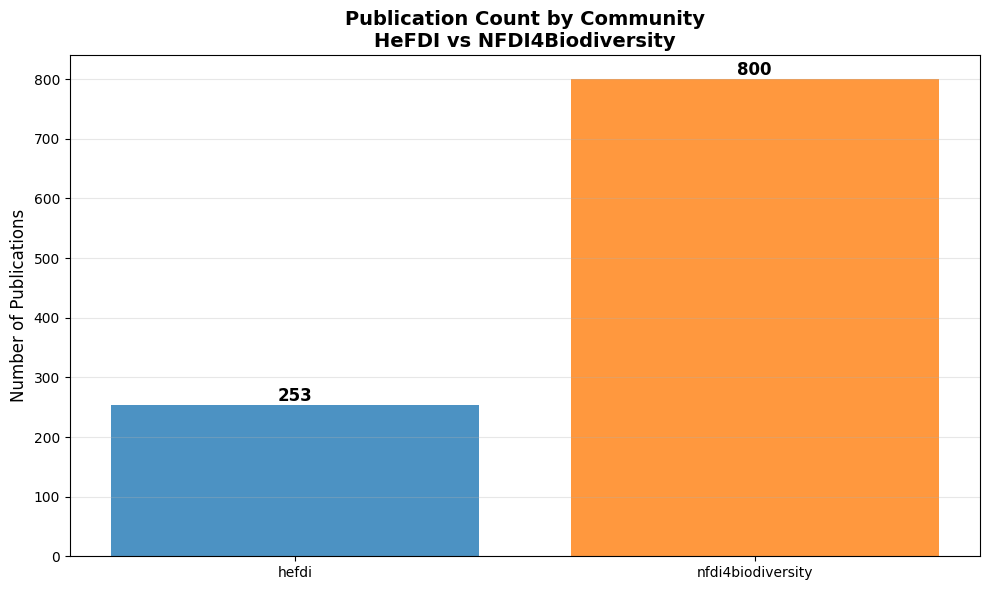

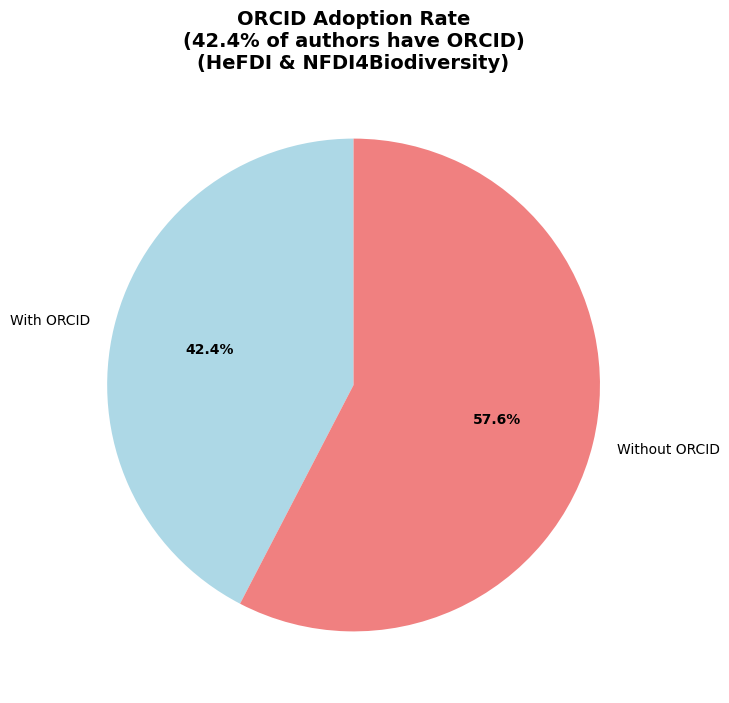

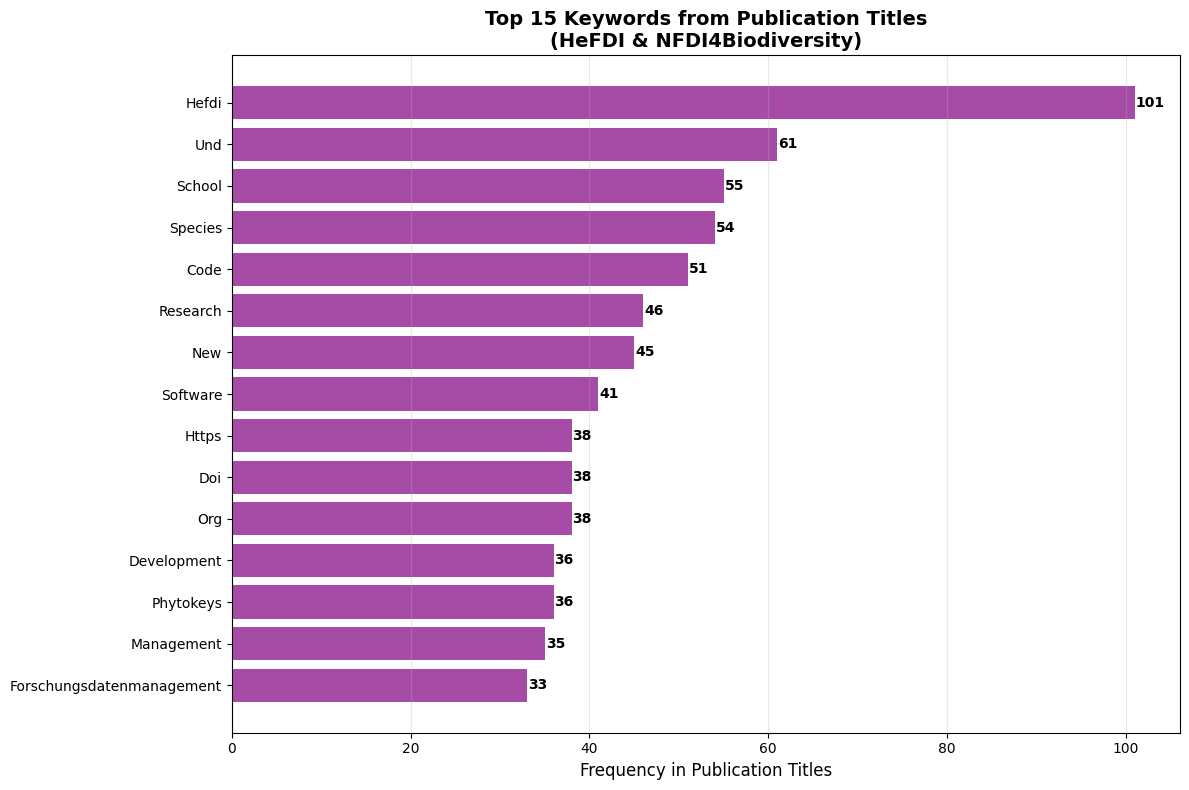

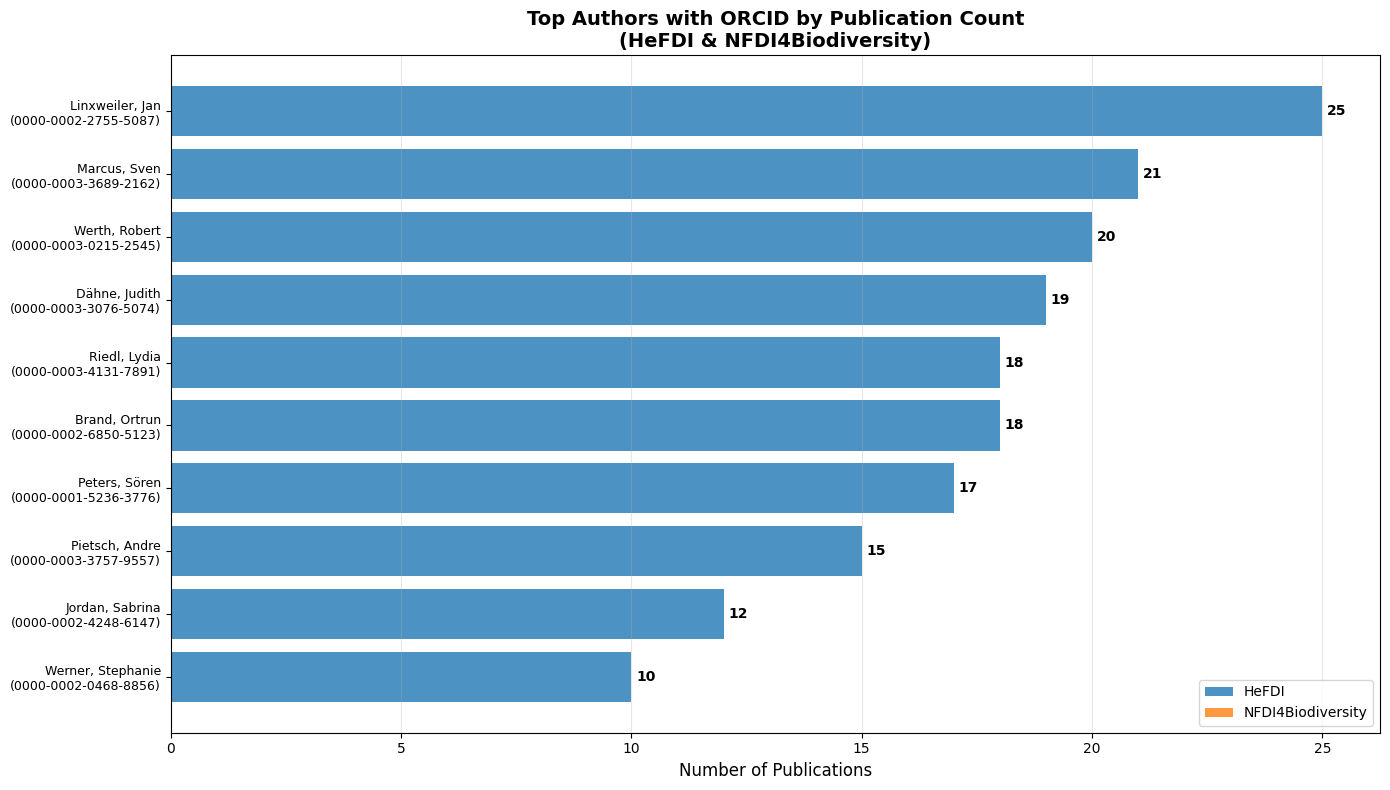

/tmp/ipykernel_1937203/2056494672.py:214: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  self.df['created_month'] = self.df['created'].dt.to_period('M')


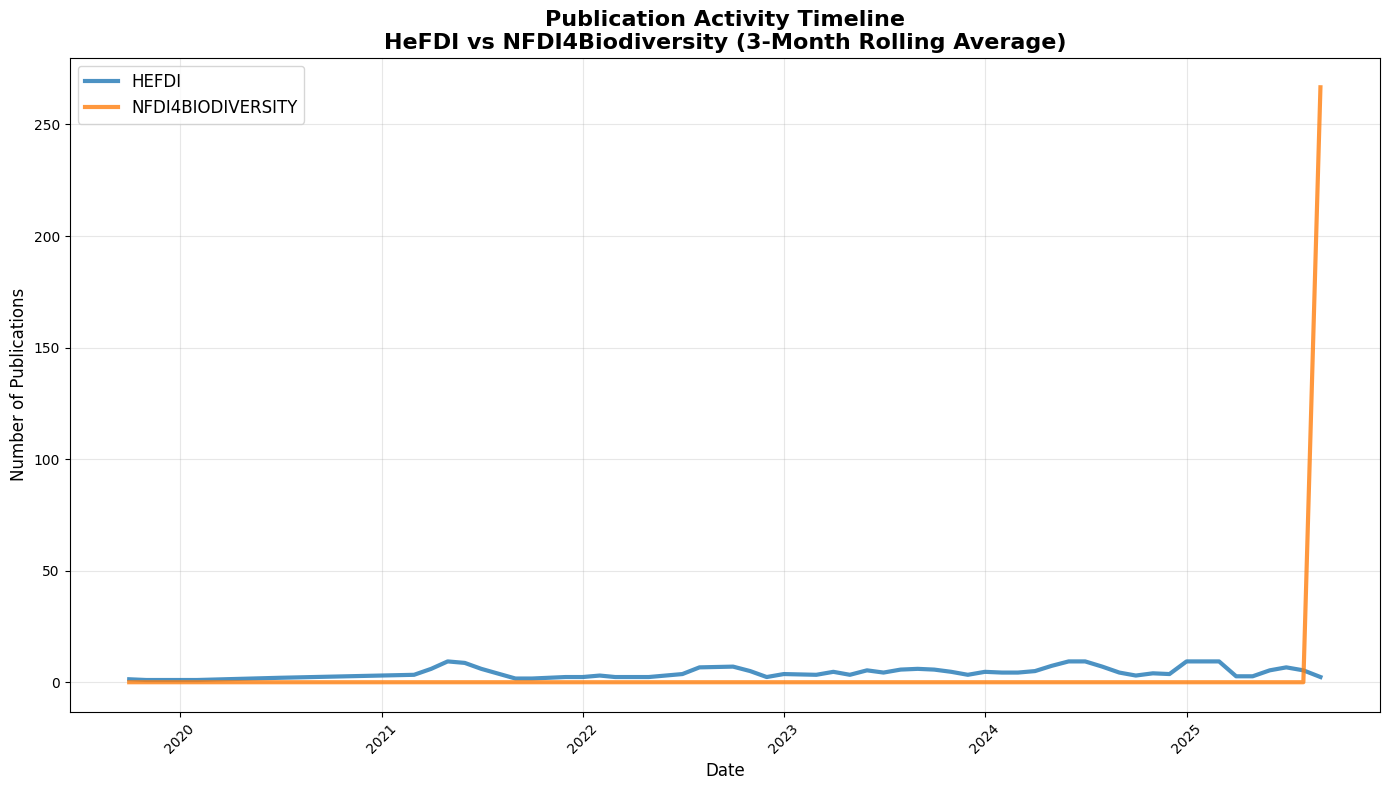

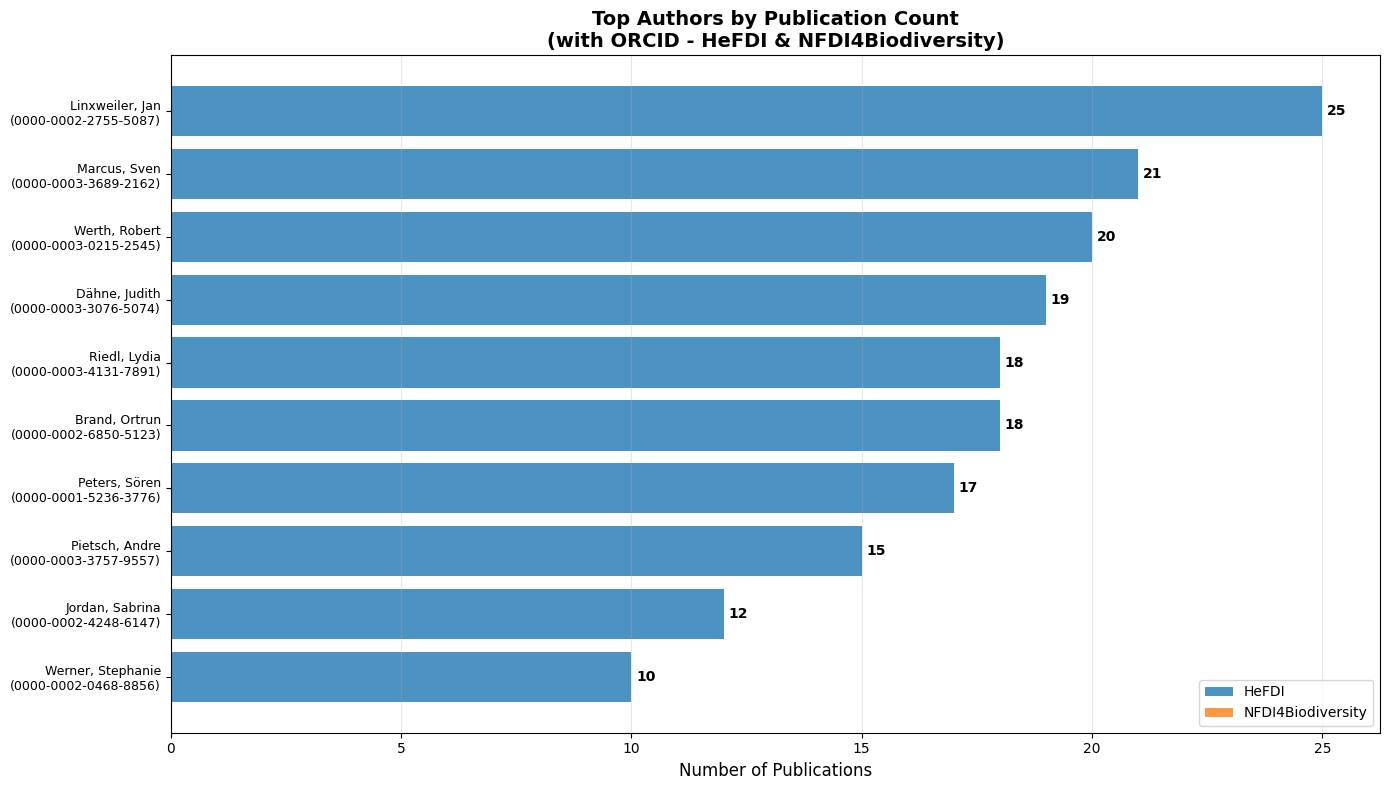

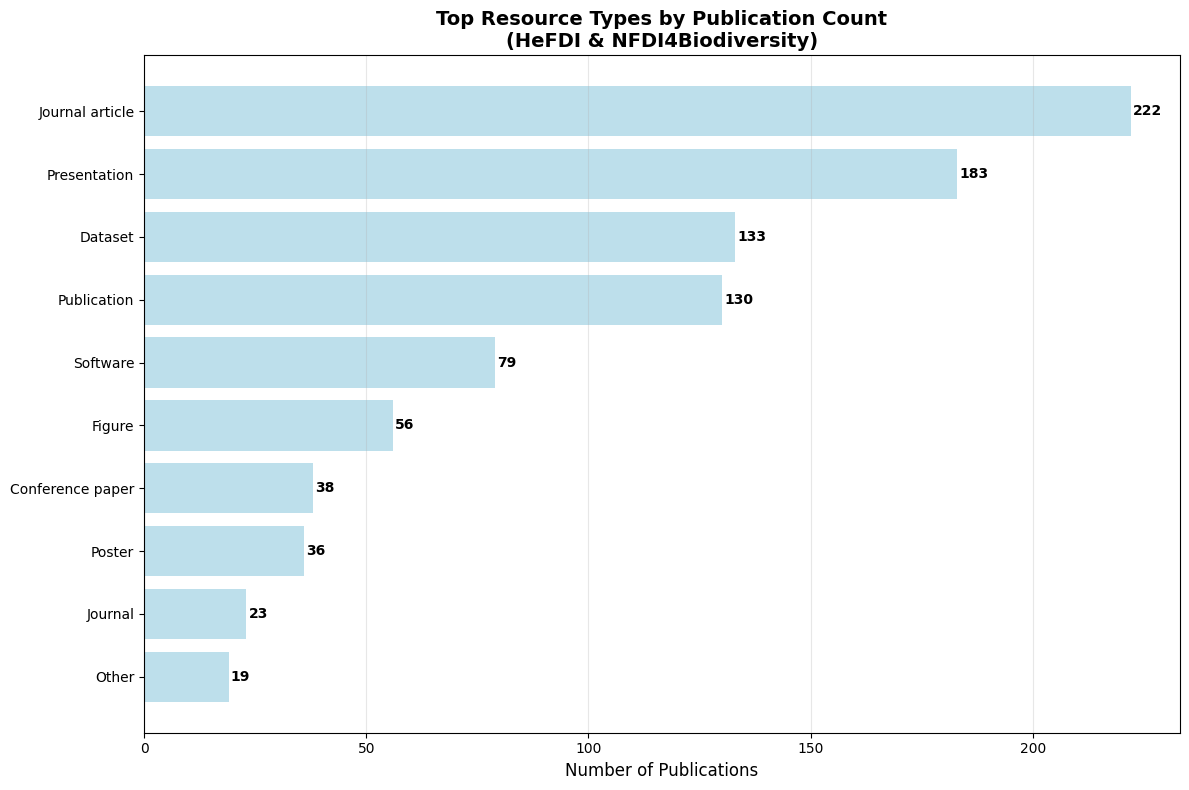

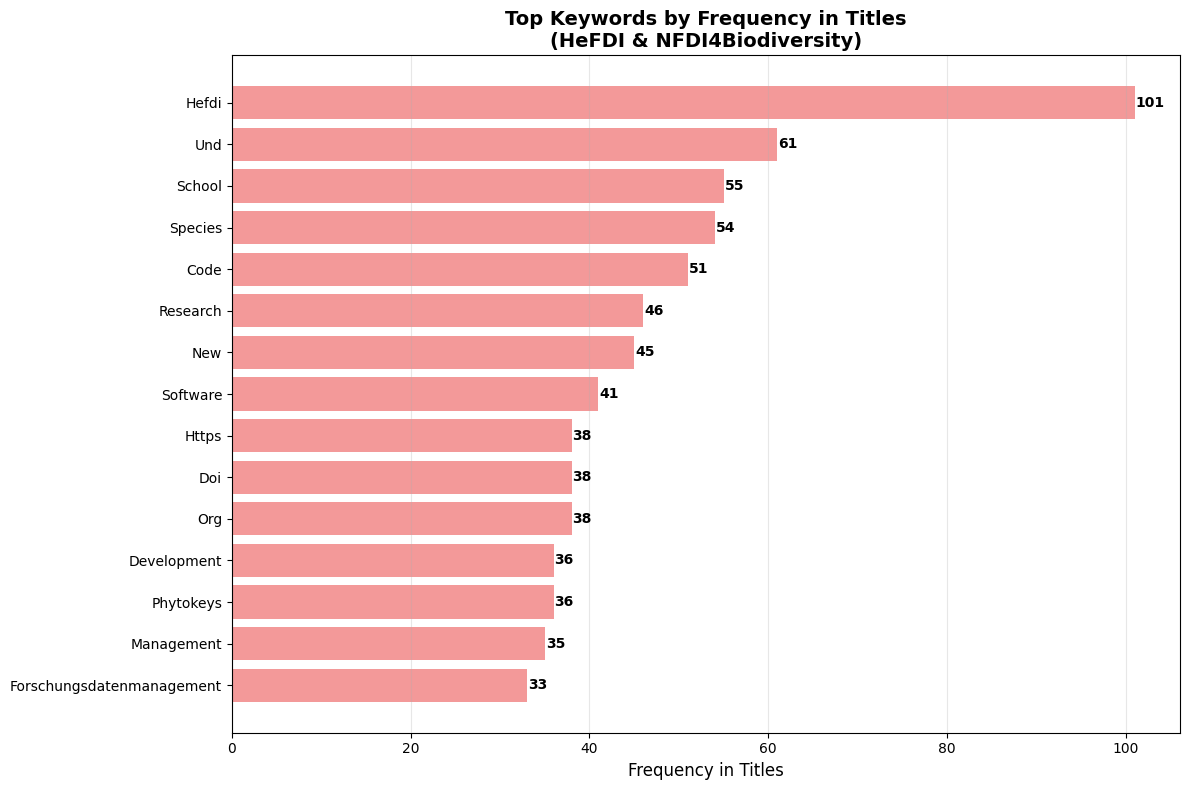

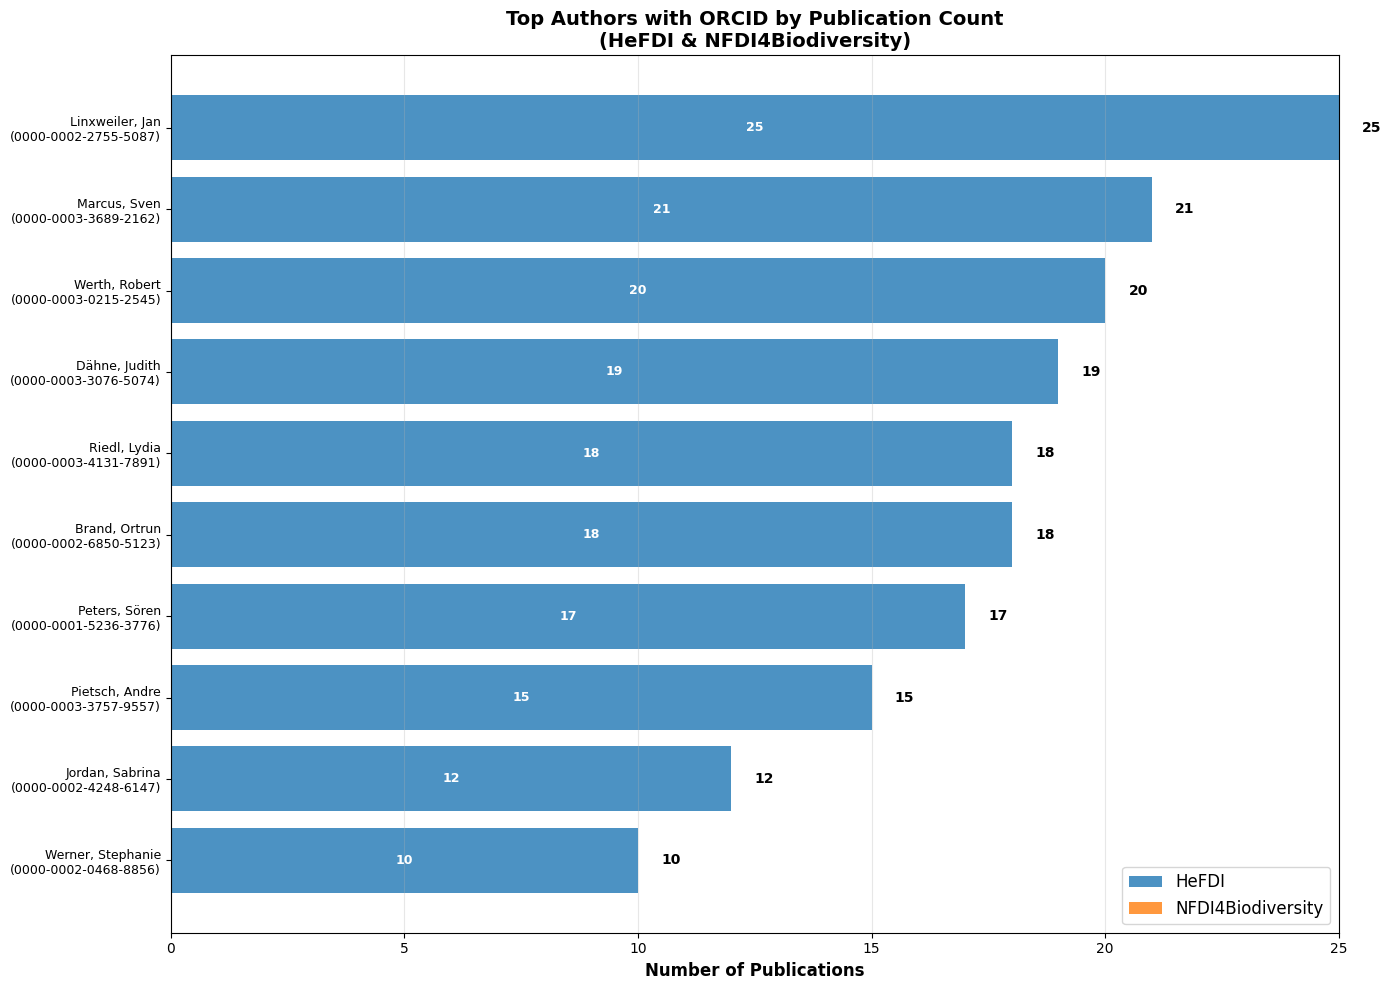


Stacked Chart Summary (Top 10 Authors with ORCID):
--------------------------------------------------
Total HeFDI publications: 175
Total NFDI4Biodiversity publications: 0
Overall total: 175
All visualizations saved to 'visualizations' directory

PROCESS COMPLETED
💾 Data file: zenodo_data.json
📊 Visualizations: visualizations/ folder
📄 Reports: CSV files in current directory


In [1]:
import requests
import csv
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from collections import Counter
from typing import Dict, List

class DataAnalyzer:
    """Handles data analysis and visualization for Zenodo harvest data"""
    
    def __init__(self):
        self.df = None
        
    def load_data(self, records: List[Dict]):
        """Load records into pandas DataFrame for analysis"""
        self.df = pd.DataFrame(records)
        if not self.df.empty:
            self.df['publication_date'] = pd.to_datetime(self.df['publication_date'], errors='coerce')
            self.df['created'] = pd.to_datetime(self.df['created'], errors='coerce')
            self.df['updated'] = pd.to_datetime(self.df['updated'], errors='coerce')
        return self.df
    
    def normalize_affiliations(self, affiliations_list):
        """Normalize affiliation names to handle variations"""
        normalized_mapping = {
            'philipps university of marburg': 'Philipps University Marburg',
            'philipps-universität marburg': 'Philipps University Marburg',
            'philipps-universität marburg -': 'Philipps University Marburg',
            'tu braunschweig': 'TU Braunschweig',
            'technische universität braunschweig': 'TU Braunschweig',
            'technische universität braunschweig -': 'TU Braunschweig',
            'technische universität dresden': 'TU Dresden',
            'tu dresden': 'TU Dresden',
            'paderborn university': 'Paderborn University',
            'Frankfurt university of applied sciences: Frankfurt Am Main, Hessen, DE': 'Frankfurt University of Applied Sciences',
            'Frankfurt UAS': 'Frankfurt University of Applied Sciences',
            'UAS Frankfurt': 'Frankfurt University of Applied Sciences',
            'frankfurt university of applied sciences': 'Frankfurt University of Applied Sciences',
            'darmstadt university of applied sciences': 'Darmstadt University of Applied Sciences',
            'university of bonn': 'University of Bonn',
            'universität bonn': 'University of Bonn'
        }
        
        normalized = []
        for affil in affiliations_list:
            if not affil:
                continue
            affil_lower = affil.lower().strip()
            if affil_lower in normalized_mapping:
                normalized.append(normalized_mapping[affil_lower])
            else:
                normalized.append(affil)
        
        return normalized
    
    def top_authors_by_publications_community(self, top_n: int = 15):
        """Analyze top authors by publication count for each community"""
        if self.df is None or self.df.empty:
            return {}
            
        community_author_counts = {}
        
        for community in ['hefdi', 'nfdi4biodiversity']:
            community_df = self.df[self.df['community'] == community]
            author_counts = Counter()
            
            for authors_list in community_df['authors']:
                for author in authors_list:
                    if author['name'] and author['name'].strip():
                        author_counts[author['name']] += 1
            
            community_author_counts[community] = author_counts.most_common(top_n)
        
        return community_author_counts
    
    def resource_type_analysis(self):
        """Analyze distribution of resource types"""
        if self.df is None or self.df.empty:
            return pd.Series()
        return self.df['resource_type'].value_counts()
    
    def affiliation_analysis(self):
        """Analyze publications by affiliation with normalization"""
        if self.df is None or self.df.empty:
            return Counter()
            
        affil_counts = Counter()
        for affil_list in self.df['affiliations']:
            normalized_affils = self.normalize_affiliations(affil_list)
            for affil in normalized_affils:
                if affil and affil.strip():
                    affil_counts[affil] += 1
        
        return affil_counts
    
    def orcid_adoption_analysis(self):
        """Analyze ORCID adoption rates"""
        if self.df is None or self.df.empty:
            return {'total_authors': 0, 'authors_with_orcid': 0, 'adoption_rate': 0}
            
        total_authors = 0
        authors_with_orcid = 0
        
        for authors_list in self.df['authors']:
            for author in authors_list:
                if author['name'] and author['name'].strip():
                    total_authors += 1
                    if author.get('orcid') and author['orcid'].strip():
                        authors_with_orcid += 1
        
        return {
            'total_authors': total_authors,
            'authors_with_orcid': authors_with_orcid,
            'adoption_rate': (authors_with_orcid / total_authors * 100) if total_authors > 0 else 0
        }
    
    def temporal_analysis_communities(self):
        """Analyze publication trends over time for both communities"""
        if self.df is None or self.df.empty:
            return pd.DataFrame()
            
        start_date = pd.Timestamp('2015-01-01')
        end_date = pd.Timestamp.now()
        filtered_df = self.df[(self.df['publication_date'] >= start_date) & 
                             (self.df['publication_date'] <= end_date)]
        
        if filtered_df.empty:
            return pd.DataFrame()
        
        temporal_data = filtered_df.groupby([
            'community', 
            filtered_df['publication_date'].dt.to_period('M')
        ]).size().unstack(fill_value=0)
        
        return temporal_data
    
    def community_comparison(self):
        """Compare metrics between communities"""
        if self.df is None or self.df.empty:
            return {'publication_count': {}, 'avg_authors_per_pub': {}}
            
        comparison = {
            'publication_count': self.df['community'].value_counts().to_dict(),
            'avg_authors_per_pub': self.df.groupby('community')['authors'].apply(
                lambda x: np.mean([len(auth_list) for auth_list in x]) if len(x) > 0 else 0
            ).to_dict()
        }
        return comparison

    def extract_keywords_from_titles(self):
        """Extract keywords from publication titles for analysis"""
        if self.df is None or self.df.empty:
            return Counter()
            
        common_words = {'the', 'and', 'for', 'with', 'using', 'based', 'from', 'data', 'study', 'analysis', 
                       'method', 'approach', 'model', 'system', 'application', 'framework'}
        
        keyword_counts = Counter()
        
        for title in self.df['title'].dropna():
            if isinstance(title, str):
                words = re.findall(r'\b[a-zA-Z]{3,}\b', title.lower())
                for word in words:
                    if word not in common_words and len(word) > 2:
                        keyword_counts[word] += 1
        
        return keyword_counts

    def get_top_orcid_authors(self, top_n: int = 10):
        """Get authors with ORCIDs and their publication counts"""
        if self.df is None or self.df.empty:
            return {}
            
        orcid_authors = {}
        
        for _, row in self.df.iterrows():
            for author in row['authors']:
                if author.get('orcid') and author['orcid'].strip() and author['name']:
                    orcid = author['orcid']
                    name = author['name']
                    community = row['community']
                    
                    if orcid not in orcid_authors:
                        orcid_authors[orcid] = {
                            'name': name,
                            'publication_count': 0,
                            'community': community
                        }
                    orcid_authors[orcid]['publication_count'] += 1
        
        sorted_orcids = sorted(orcid_authors.items(), key=lambda x: x[1]['publication_count'], reverse=True)
        return dict(sorted_orcids[:top_n])

    def get_publication_activity_timeline(self):
        """Get monthly publication activity for timeline analysis"""
        if self.df is None or self.df.empty:
            return pd.DataFrame()
            
        self.df['created_month'] = self.df['created'].dt.to_period('M')
        
        timeline_data = self.df.groupby(['community', 'created_month']).size().unstack(fill_value=0)
        return timeline_data

    def get_authors_with_orcid_and_metrics(self):
        """Get authors with ORCIDs and their metrics for both communities"""
        if self.df is None or self.df.empty:
            return {}
            
        author_metrics = {}
        
        for _, row in self.df.iterrows():
            for author in row['authors']:
                if author.get('orcid') and author['orcid'].strip() and author['name']:
                    orcid = author['orcid']
                    name = author['name']
                    community = row['community']
                    
                    if orcid not in author_metrics:
                        author_metrics[orcid] = {
                            'name': name,
                            'publication_count': 0,
                            'community': community,
                            'publications': []
                        }
                    author_metrics[orcid]['publication_count'] += 1
                    author_metrics[orcid]['publications'].append(row['id'])
        
        return author_metrics

    def get_top_orcid_authors_by_community(self, top_n: int = 10):
        """Get authors with ORCIDs and their publication counts split by community"""
        if self.df is None or self.df.empty:
            return {}
        
        # Structure: {orcid: {'name': name, 'hefdi': count, 'nfdi4biodiversity': count, 'total': count}}
        orcid_authors = {}
        
        for _, row in self.df.iterrows():
            for author in row['authors']:
                if author.get('orcid') and author['orcid'].strip() and author['name']:
                    orcid = author['orcid']
                    name = author['name']
                    community = row['community']
                    
                    if orcid not in orcid_authors:
                        orcid_authors[orcid] = {
                            'name': name,
                            'hefdi': 0,
                            'nfdi4biodiversity': 0,
                            'total': 0
                        }
                    
                    # Count by community
                    if community == 'hefdi':
                        orcid_authors[orcid]['hefdi'] += 1
                    elif community == 'nfdi4biodiversity':
                        orcid_authors[orcid]['nfdi4biodiversity'] += 1
                    
                    orcid_authors[orcid]['total'] += 1
        
        # Sort by total publications and return top N
        sorted_orcids = sorted(orcid_authors.items(), 
                              key=lambda x: x[1]['total'], 
                              reverse=True)
        return dict(sorted_orcids[:top_n])


class VisualizationEngine:
    """Handles creation of all visualizations using actual data"""
    
    def __init__(self, analyzer: DataAnalyzer):
        self.analyzer = analyzer
        self.output_dir = 'visualizations'
        os.makedirs(self.output_dir, exist_ok=True)
    
    def create_top_authors_comparison_chart(self, top_n: int = 15):
        """Create comparison bar chart of top authors by publications in both communities"""
        community_authors = self.analyzer.top_authors_by_publications_community(top_n)
        
        if not community_authors:
            print("No author data available for visualization")
            return
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
        
        if community_authors.get('hefdi'):
            hefdi_authors, hefdi_counts = zip(*community_authors['hefdi'])
            bars1 = ax1.barh(range(len(hefdi_authors)), hefdi_counts, color='#1f77b4', alpha=0.8)
            ax1.set_yticks(range(len(hefdi_authors)))
            ax1.set_yticklabels(hefdi_authors, fontsize=10)
            ax1.set_xlabel('Number of Publications', fontsize=12)
            ax1.set_title('Top Authors by Publications in HeFDI', fontsize=14, fontweight='bold')
            ax1.invert_yaxis()
            ax1.grid(axis='x', alpha=0.3)
            
            for bar, count in zip(bars1, hefdi_counts):
                ax1.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                        str(count), ha='left', va='center', fontweight='bold')
        
        if community_authors.get('nfdi4biodiversity'):
            nfdi_authors, nfdi_counts = zip(*community_authors['nfdi4biodiversity'])
            bars2 = ax2.barh(range(len(nfdi_authors)), nfdi_counts, color='#ff7f0e', alpha=0.8)
            ax2.set_yticks(range(len(nfdi_authors)))
            ax2.set_yticklabels(nfdi_authors, fontsize=10)
            ax2.set_xlabel('Number of Publications', fontsize=12)
            ax2.set_title('Top Authors by Publications in NFDI4Biodiversity', fontsize=14, fontweight='bold')
            ax2.invert_yaxis()
            ax2.grid(axis='x', alpha=0.3)
            
            for bar, count in zip(bars2, nfdi_counts):
                ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                        str(count), ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/top_authors_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_resource_type_chart(self):
        """Create pie chart of resource type distribution"""
        resource_types = self.analyzer.resource_type_analysis()
        
        if resource_types.empty:
            print("No resource type data available")
            return
        
        total = resource_types.sum()
        threshold = total * 0.01
        filtered_types = resource_types[resource_types >= threshold]
        
        others_count = resource_types[resource_types < threshold].sum()
        if others_count > 0:
            filtered_types['Others'] = others_count
        
        plt.figure(figsize=(10, 8))
        colors = plt.cm.Set3(np.linspace(0, 1, len(filtered_types)))
        wedges, texts, autotexts = plt.pie(filtered_types.values, labels=filtered_types.index, 
                                          autopct='%1.1f%%', colors=colors, startangle=90)
        
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
            
        plt.title('Distribution of Resource Types\n(HeFDI & NFDI4Biodiversity)', fontsize=14, fontweight='bold')
        plt.savefig(f'{self.output_dir}/resource_types.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_affiliation_chart(self, top_n: int = 15):
        """Create clean bar chart of top affiliations with normalized names"""
        affiliations = self.analyzer.affiliation_analysis()
        top_affiliations = affiliations.most_common(top_n)
        
        if not top_affiliations:
            print("No affiliation data available")
            return
            
        affils, counts = zip(*top_affiliations)
        
        truncated_affils = []
        for affil in affils:
            if len(affil) > 40:
                truncated_affils.append(affil[:37] + '...')
            else:
                truncated_affils.append(affil)
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(range(len(truncated_affils)), counts, color='lightgreen', alpha=0.8)
        plt.yticks(range(len(truncated_affils)), truncated_affils, fontsize=10)
        plt.xlabel('Number of Publications', fontsize=12)
        plt.title(f'Top {top_n} Affiliations by Publication Count\n(HeFDI & NFDI4Biodiversity)', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        
        for bar, count, affil in zip(bars, counts, affils):
            plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                    str(count), ha='left', va='center', fontsize=10, fontweight='bold')
        
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/top_affiliations.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_temporal_trends_comparison(self):
        """Create line chart of publication trends over time for both communities"""
        temporal_data = self.analyzer.temporal_analysis_communities()
        
        if temporal_data.empty:
            print("No temporal data available")
            return
            
        plt.figure(figsize=(14, 8))
        
        colors = {'hefdi': '#1f77b4', 'nfdi4biodiversity': '#ff7f0e'}
        line_styles = {'hefdi': '-', 'nfdi4biodiversity': '--'}
        
        for community in ['hefdi', 'nfdi4biodiversity']:
            if community in temporal_data.index:
                community_data = temporal_data.loc[community]
                if not community_data.empty:
                    dates = community_data.index.to_timestamp()
                    plt.plot(dates, community_data.values, 
                            linewidth=3, 
                            label=community.upper(), 
                            color=colors.get(community, 'gray'),
                            linestyle=line_styles.get(community, '-'),
                            marker='o', markersize=4)
        
        plt.title('Publication Trends Over Time (2015 - Today)\nHeFDI vs NFDI4Biodiversity', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Number of Publications', fontsize=12)
        plt.legend(fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/temporal_trends_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_community_comparison(self):
        """Create comparison charts between communities"""
        comparison = self.analyzer.community_comparison()
        
        if not comparison['publication_count']:
            print("No community comparison data available")
            return
            
        filtered_communities = {}
        for community in ['hefdi', 'nfdi4biodiversity']:
            if community in comparison['publication_count']:
                filtered_communities[community] = comparison['publication_count'][community]
        
        if not filtered_communities:
            return
            
        plt.figure(figsize=(10, 6))
        communities = list(filtered_communities.keys())
        counts = list(filtered_communities.values())
        
        bars = plt.bar(communities, counts, color=['#1f77b4', '#ff7f0e'], alpha=0.8)
        plt.title('Publication Count by Community\nHeFDI vs NFDI4Biodiversity', fontsize=14, fontweight='bold')
        plt.ylabel('Number of Publications', fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/community_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_orcid_adoption_chart(self):
        """Create pie chart showing ORCID adoption"""
        orcid_stats = self.analyzer.orcid_adoption_analysis()
        
        if orcid_stats['total_authors'] == 0:
            print("No ORCID data available")
            return
            
        labels = ['With ORCID', 'Without ORCID']
        sizes = [orcid_stats['authors_with_orcid'], 
                orcid_stats['total_authors'] - orcid_stats['authors_with_orcid']]
        colors = ['lightblue', 'lightcoral']
        
        plt.figure(figsize=(8, 8))
        wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, 
                                          autopct='%1.1f%%', startangle=90)
        
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
            
        plt.title(f'ORCID Adoption Rate\n({orcid_stats["adoption_rate"]:.1f}% of authors have ORCID)\n(HeFDI & NFDI4Biodiversity)', 
                 fontsize=14, fontweight='bold')
        plt.savefig(f'{self.output_dir}/orcid_adoption.png', dpi=300, bbox_inches='tight')
        plt.show()

    def create_top_keywords_chart(self, top_n: int = 15):
        """Create bar chart of top keywords extracted from titles"""
        keywords_data = self.analyzer.extract_keywords_from_titles()
        
        if not keywords_data:
            print("No keyword data available")
            return
            
        top_keywords = keywords_data.most_common(top_n)
        
        if not top_keywords:
            print("No meaningful keywords found")
            return
            
        keywords, counts = zip(*top_keywords)
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(range(len(keywords)), counts, color='purple', alpha=0.7)
        plt.yticks(range(len(keywords)), [k.title() for k in keywords])
        plt.xlabel('Frequency in Publication Titles', fontsize=12)
        plt.title(f'Top {top_n} Keywords from Publication Titles\n(HeFDI & NFDI4Biodiversity)', 
                 fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        
        for bar, count in zip(bars, counts):
            plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                    str(count), ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/top_keywords.png', dpi=300, bbox_inches='tight')
        plt.show()

    def create_top_orcid_authors_chart(self, top_n: int = 10):
        """Create bar chart of top authors with ORCIDs"""
        orcid_authors = self.analyzer.get_top_orcid_authors(top_n)
        
        if not orcid_authors:
            print("No ORCID author data available")
            return
            
        author_labels = []
        publication_counts = []
        communities = []
        
        for orcid, info in orcid_authors.items():
            author_labels.append(f"{info['name']}\n({orcid})")
            publication_counts.append(info['publication_count'])
            communities.append(info['community'])
        
        colors = ['#1f77b4' if comm == 'hefdi' else '#ff7f0e' for comm in communities]
        
        plt.figure(figsize=(14, 8))
        bars = plt.barh(range(len(author_labels)), publication_counts, color=colors, alpha=0.8)
        plt.yticks(range(len(author_labels)), author_labels, fontsize=9)
        plt.xlabel('Number of Publications', fontsize=12)
        plt.title(f'Top Authors with ORCID by Publication Count\n(HeFDI & NFDI4Biodiversity)', 
                 fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        
        for bar, count in zip(bars, publication_counts):
            plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                    str(count), ha='left', va='center', fontweight='bold')
        
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#1f77b4', alpha=0.8, label='HeFDI'),
            Patch(facecolor='#ff7f0e', alpha=0.8, label='NFDI4Biodiversity')
        ]
        plt.legend(handles=legend_elements, loc='lower right')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/top_orcid_authors.png', dpi=300, bbox_inches='tight')
        plt.show()

    def create_publication_activity_timeline(self):
        """Create clean timeline of publication activity"""
        timeline_data = self.analyzer.get_publication_activity_timeline()
        
        if timeline_data.empty:
            print("No timeline data available")
            return
            
        plt.figure(figsize=(14, 8))
        
        colors = {'hefdi': '#1f77b4', 'nfdi4biodiversity': '#ff7f0e'}
        
        for community in ['hefdi', 'nfdi4biodiversity']:
            if community in timeline_data.index:
                community_data = timeline_data.loc[community]
                if not community_data.empty:
                    dates = community_data.index.to_timestamp()
                    smoothed_data = community_data.rolling(window=3, center=True).mean()
                    plt.plot(dates, smoothed_data, 
                            linewidth=3, 
                            label=community.upper(),
                            color=colors.get(community, 'gray'),
                            alpha=0.8)
        
        plt.title('Publication Activity Timeline\nHeFDI vs NFDI4Biodiversity (3-Month Rolling Average)', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Number of Publications', fontsize=12)
        plt.legend(fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/publication_activity_timeline.png', dpi=300, bbox_inches='tight')
        plt.show()

    def create_top_authors_by_publication_count(self, top_n: int = 10):
        """Create bar chart of top authors by publication count with ORCID"""
        orcid_authors = self.analyzer.get_top_orcid_authors(top_n)
        
        if not orcid_authors:
            print("No ORCID author data available for publication count chart")
            return
            
        author_labels = []
        publication_counts = []
        communities = []
        
        for orcid, info in orcid_authors.items():
            author_labels.append(f"{info['name']}\n({orcid})")
            publication_counts.append(info['publication_count'])
            communities.append(info['community'])
        
        colors = ['#1f77b4' if comm == 'hefdi' else '#ff7f0e' for comm in communities]
        
        plt.figure(figsize=(14, 8))
        bars = plt.barh(range(len(author_labels)), publication_counts, color=colors, alpha=0.8)
        plt.yticks(range(len(author_labels)), author_labels, fontsize=9)
        plt.xlabel('Number of Publications', fontsize=12)
        plt.title(f'Top Authors by Publication Count\n(with ORCID - HeFDI & NFDI4Biodiversity)', 
                 fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        
        for bar, count in zip(bars, publication_counts):
            plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                    str(count), ha='left', va='center', fontweight='bold')
        
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#1f77b4', alpha=0.8, label='HeFDI'),
            Patch(facecolor='#ff7f0e', alpha=0.8, label='NFDI4Biodiversity')
        ]
        plt.legend(handles=legend_elements, loc='lower right')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/top_authors_by_publications.png', dpi=300, bbox_inches='tight')
        plt.show()

    def create_resource_types_by_publications_chart(self, top_n: int = 10):
        """Create bar chart of resource types by publication count"""
        resource_types = self.analyzer.resource_type_analysis()
        
        if resource_types.empty:
            print("No resource type data available")
            return
        
        top_types = resource_types.head(top_n)
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(range(len(top_types)), top_types.values, color='lightblue', alpha=0.8)
        plt.yticks(range(len(top_types)), top_types.index)
        plt.xlabel('Number of Publications', fontsize=12)
        plt.title(f'Top Resource Types by Publication Count\n(HeFDI & NFDI4Biodiversity)', 
                 fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        
        for bar, count in zip(bars, top_types.values):
            plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                    str(int(count)), ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/resource_types_by_publications.png', dpi=300, bbox_inches='tight')
        plt.show()

    def create_keywords_by_frequency_chart(self, top_n: int = 15):
        """Create bar chart of keywords by frequency"""
        keywords_data = self.analyzer.extract_keywords_from_titles()
        
        if not keywords_data:
            print("No keyword data available")
            return
            
        top_keywords = keywords_data.most_common(top_n)
        
        if not top_keywords:
            print("No meaningful keywords found")
            return
            
        keywords, counts = zip(*top_keywords)
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(range(len(keywords)), counts, color='lightcoral', alpha=0.8)
        plt.yticks(range(len(keywords)), [k.title() for k in keywords])
        plt.xlabel('Frequency in Titles', fontsize=12)
        plt.title(f'Top Keywords by Frequency in Titles\n(HeFDI & NFDI4Biodiversity)', 
                 fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        
        for bar, count in zip(bars, counts):
            plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                    str(count), ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/keywords_by_frequency.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    def create_top_orcid_authors_side_by_side(self, top_n: int = 10):
        """Create stacked bar chart of top authors with ORCID showing community distribution"""
        orcid_authors = self.analyzer.get_top_orcid_authors_by_community(top_n)
        
        if not orcid_authors:
            print("No ORCID author data available for side-by-side chart")
            return
        
        # Prepare data
        author_names = []
        hefdi_counts = []
        nfdi_counts = []
        
        for orcid, info in orcid_authors.items():
            author_names.append(info['name'])
            hefdi_counts.append(info['hefdi'])
            nfdi_counts.append(info['nfdi4biodiversity'])
        
        # Create side-by-side bars
        x = np.arange(len(author_names))
        width = 0.35
        
        plt.figure(figsize=(16, 10))
        
        bars1 = plt.bar(x - width/2, hefdi_counts, width, label='HeFDI', color='#1f77b4', alpha=0.8)
        bars2 = plt.bar(x + width/2, nfdi_counts, width, label='NFDI4Biodiversity', color='#ff7f0e', alpha=0.8)
        
        plt.xlabel('Authors', fontsize=12, fontweight='bold')
        plt.ylabel('Number of Publications', fontsize=12, fontweight='bold')
        plt.title(f'Top Authors with ORCID - Publications by Community', fontsize=14, fontweight='bold')
        plt.xticks(x, author_names, rotation=45, ha='right', fontsize=10)
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                            f'{int(height)}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/top_orcid_authors_side_by_side.png', dpi=300, bbox_inches='tight')
        plt.show()

    def create_top_orcid_authors_stacked_chart(self, top_n: int = 10):
        """Create stacked bar chart of top authors with ORCID showing community distribution"""
        orcid_authors = self.analyzer.get_top_orcid_authors_by_community(top_n)
        
        if not orcid_authors:
            print("No ORCID author data available for stacked chart")
            return
        
        # Prepare data for plotting
        author_labels = []
        hefdi_counts = []
        nfdi_counts = []
        total_counts = []
        
        for orcid, info in orcid_authors.items():
            author_labels.append(f"{info['name']}\n({orcid})")
            hefdi_counts.append(info['hefdi'])
            nfdi_counts.append(info['nfdi4biodiversity'])
            total_counts.append(info['total'])
        
        # Create the stacked bar chart
        plt.figure(figsize=(14, 10))
        
        # Plot HeFDI bars (bottom)
        bars_hefdi = plt.barh(range(len(author_labels)), hefdi_counts, 
                             color='#1f77b4', alpha=0.8, label='HeFDI')
        
        # Plot NFDI4Biodiversity bars on top of HeFDI bars
        bars_nfdi = plt.barh(range(len(author_labels)), nfdi_counts, 
                            left=hefdi_counts,  # Stack on top of HeFDI counts
                            color='#ff7f0e', alpha=0.8, label='NFDI4Biodiversity')
        
        # Customize the chart
        plt.yticks(range(len(author_labels)), author_labels, fontsize=9)
        plt.xlabel('Number of Publications', fontsize=12, fontweight='bold')
        plt.title(f'Top Authors with ORCID by Publication Count\n(HeFDI & NFDI4Biodiversity)', 
                 fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()  # Highest count at the top
        plt.grid(axis='x', alpha=0.3)
        
        # Add value labels on each segment
        for i, (hefdi, nfdi, total) in enumerate(zip(hefdi_counts, nfdi_counts, total_counts)):
            # Label for HeFDI segment (if > 0)
            if hefdi > 0:
                plt.text(hefdi/2, i, str(hefdi), 
                        ha='center', va='center', fontweight='bold', fontsize=9,
                        color='white' if hefdi > max(hefdi_counts)*0.3 else 'black')
            
            # Label for NFDI segment (if > 0)
            if nfdi > 0:
                plt.text(hefdi + nfdi/2, i, str(nfdi), 
                        ha='center', va='center', fontweight='bold', fontsize=9,
                        color='white' if nfdi > max(nfdi_counts)*0.3 else 'black')
            
            # Total count at the end of the bar
            plt.text(total + 0.5, i, str(total), 
                    ha='left', va='center', fontweight='bold', fontsize=10)
        
        # Add legend
        plt.legend(loc='lower right', fontsize=12)
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/top_orcid_authors_stacked.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print summary statistics
        print(f"\nStacked Chart Summary (Top {top_n} Authors with ORCID):")
        print("-" * 50)
        total_hefdi = sum(hefdi_counts)
        total_nfdi = sum(nfdi_counts)
        print(f"Total HeFDI publications: {total_hefdi}")
        print(f"Total NFDI4Biodiversity publications: {total_nfdi}")
        print(f"Overall total: {total_hefdi + total_nfdi}")

    def generate_comprehensive_report(self):
        """Generate all visualizations using actual data"""
        print("Generating comprehensive analytics report...")
        
        # Original graphs
        self.create_top_authors_comparison_chart()
        self.create_resource_type_chart()
        self.create_affiliation_chart()
        self.create_temporal_trends_comparison()
        self.create_community_comparison()
        self.create_orcid_adoption_chart()
        self.create_top_keywords_chart()
        self.create_top_orcid_authors_chart()
        self.create_publication_activity_timeline()
        
        # New graphs with real data
        self.create_top_authors_by_publication_count()
        self.create_resource_types_by_publications_chart()
        self.create_keywords_by_frequency_chart()
        
        # NEW: Stacked ORCID authors chart
        self.create_top_orcid_authors_stacked_chart()
        create_keywords_by_frequency_chart
        
        print(f"All visualizations saved to '{self.output_dir}' directory")


class ZenodoHarvester:
    def __init__(self):
        self.base_url = "https://zenodo.org/api/records"
        self.communities = {
            'nfdi4biodiversity': 'nfdi4biodiversity',
            'hefdi': 'hefdi'
        }
        self.last_update_file = 'last_harvest.txt'
        self.analyzer = DataAnalyzer()
        self.visualizer = None
        
    def get_last_harvest_date(self) -> str:
        try:
            with open(self.last_update_file, 'r') as f:
                return f.read().strip()
        except FileNotFoundError:
            default_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
            return default_date
    
    def update_last_harvest_date(self):
        current_date = datetime.now().strftime('%Y-%m-%d')
        with open(self.last_update_file, 'w') as f:
            f.write(current_date)
    
    def test_api_connection(self):
        try:
            test_params = {'size': 1, 'page': 1}
            response = requests.get(self.base_url, params=test_params, timeout=30)
            return response.status_code == 200
        except Exception:
            return False
    
    def harvest_community_data(self, community: str, community_id: str) -> List[Dict]:
        all_records = []
        page = 1
        size = 10
        
        while True:
            try:
                params = {
                    'communities': community_id,
                    'size': size,
                    'page': page,
                    'sort': 'mostrecent',
                    'all_versions': True
                }
                
                response = requests.get(self.base_url, params=params, timeout=30)
                response.raise_for_status()
                data = response.json()
                
                hits = data.get('hits', {}).get('hits', [])
                
                if not hits:
                    break
                
                for hit in hits:
                    record = self.process_record(hit, community)
                    if record:
                        all_records.append(record)
                
                page += 1
                
                if page > 5:
                    break
                    
            except requests.exceptions.RequestException:
                break
            except Exception:
                break
        
        return all_records
    
    def process_record(self, hit: Dict, community: str) -> Dict:
        metadata = hit.get('metadata', {})
        
        authors_with_orcids = []
        creators = metadata.get('creators', [])
        
        for creator in creators:
            name = creator.get('name', '')
            orcid = creator.get('orcid', '')
            if not orcid and name:
                orcid = self.extract_orcid(name)
                name = self.normalize_name(name)
            
            authors_with_orcids.append({
                'name': name,
                'orcid': orcid,
                'affiliation': creator.get('affiliation', '')
            })
        
        affiliations = self.extract_affiliations(metadata)
        
        title = metadata.get('title', 'Untitled')
        if isinstance(title, list):
            title = ' '.join(title)
        
        return {
            'id': hit.get('id'),
            'doi': metadata.get('doi'),
            'title': title,
            'publication_date': metadata.get('publication_date'),
            'community': community,
            'authors': authors_with_orcids,
            'affiliations': affiliations,
            'created': hit.get('created'),
            'updated': hit.get('updated'),
            'resource_type': metadata.get('resource_type', {}).get('title', ''),
            'access_right': metadata.get('access_right', '')
        }
    
    def extract_orcid(self, author_string: str) -> str:
        orcid_pattern = r'\d{4}-\d{4}-\d{4}-\d{3}[\dX]'
        match = re.search(orcid_pattern, author_string)
        return match.group(0) if match else ""
    
    def normalize_name(self, name: str) -> str:
        name = re.sub(r'\d{4}-\d{4}-\d{4}-\d{3}[\dX]', '', name).strip()
        name = ' '.join(name.split())
        return name
    
    def extract_affiliations(self, metadata: Dict) -> List[str]:
        affiliations = []
        creators = metadata.get('creators', [])
        
        for creator in creators:
            affiliation = creator.get('affiliation', '')
            if affiliation:
                affiliations.append(affiliation.strip())
        
        return affiliations
    
    def run_harvest(self):
        print("Starting Zenodo harvest...")
        
        if not self.test_api_connection():
            print("Cannot connect to Zenodo API")
            return []
        
        all_records = []
        
        for community_name, community_id in self.communities.items():
            print(f"Harvesting data for {community_name}...")
            community_records = self.harvest_community_data(community_name, community_id)
            
            if community_records:
                all_records.extend(community_records)
                print(f"Found {len(community_records)} records for {community_name}")
            else:
                print(f"No records found for {community_name}")
        
        if all_records:
            self.generate_separate_reports(all_records)
            self.run_analytics(all_records)
            self.update_last_harvest_date()
            
            print(f"Harvest completed! Processed {len(all_records)} total records.")
            print(f"Analytics reports saved to 'visualizations' directory")
        else:
            print("No records were harvested.")
        
        return all_records

    def generate_separate_reports(self, all_records: List[Dict]):
        for community in self.communities.keys():
            community_records = [r for r in all_records if r['community'] == community]
            
            if community_records:
                self.generate_csv_report(community_records, f"{community}_report.csv")
                
                if community_records:
                    affiliation_stats = self.aggregate_by_affiliation(community_records, community)
                    self.generate_affiliation_report(affiliation_stats, f"{community}_affiliations.csv")

    def generate_csv_report(self, records: List[Dict], filename: str):
        try:
            with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
                fieldnames = ['id', 'doi', 'title', 'publication_date', 'community', 
                             'authors', 'affiliations', 'resource_type', 'access_right',
                             'created', 'updated']
                
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                
                for record in records:
                    record_copy = record.copy()
                    record_copy['authors'] = '; '.join([
                        f"{author['name']} ({author['orcid']})" if author['orcid'] else author['name']
                        for author in record['authors']
                    ])
                    record_copy['affiliations'] = '; '.join(record['affiliations'])
                    writer.writerow(record_copy)
            
            print(f"Generated report: {filename}")
        except Exception as e:
            print(f"Error generating {filename}: {e}")

    def aggregate_by_affiliation(self, records: List[Dict], target_community: str = None) -> Dict:
        affiliation_stats = {}
        
        for record in records:
            if target_community and record['community'] != target_community:
                continue
                
            for affiliation in record['affiliations']:
                if not affiliation:
                    continue
                    
                if affiliation not in affiliation_stats:
                    affiliation_stats[affiliation] = {
                        'publication_count': 0,
                        'records': []
                    }
                
                affiliation_stats[affiliation]['publication_count'] += 1
                affiliation_stats[affiliation]['records'].append({
                    'id': record['id'],
                    'title': record['title'],
                    'publication_date': record['publication_date']
                })
        
        return affiliation_stats

    def generate_affiliation_report(self, affiliation_stats: Dict, filename: str):
        try:
            with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
                fieldnames = ['affiliation', 'publication_count', 'record_ids']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                
                writer.writeheader()
                for affiliation, stats in affiliation_stats.items():
                    record_ids = '; '.join([str(record['id']) for record in stats['records']])
                    writer.writerow({
                        'affiliation': affiliation,
                        'publication_count': stats['publication_count'],
                        'record_ids': record_ids
                    })
            
            print(f"Generated affiliation report: {filename}")
        except Exception as e:
            print(f"Error generating affiliation report: {e}")

    def run_analytics(self, all_records: List[Dict]):
        print("\n" + "="*50)
        print("RUNNING COMPREHENSIVE ANALYTICS")
        print("="*50)
        
        try:
            df = self.analyzer.load_data(all_records)
            self.visualizer = VisualizationEngine(self.analyzer)
            
            print(f"Total records harvested: {len(all_records)}")
            community_counts = df['community'].value_counts().to_dict()
            for community, count in community_counts.items():
                print(f"  {community}: {count} records")
            
            orcid_stats = self.analyzer.orcid_adoption_analysis()
            print(f"ORCID Adoption: {orcid_stats['adoption_rate']:.1f}% of authors have ORCID")
            
            self.visualizer.generate_comprehensive_report()
            
        except Exception as e:
            print(f"Error during analytics: {e}")


def main():
    """Main function to run the complete Zenodo harvester and analytics"""
    print("=" * 60)
    print("ZENODO HARVESTER & ANALYTICS DASHBOARD")
    print("=" * 60)
    
    harvester = ZenodoHarvester()
    records = harvester.run_harvest()
    
    if records:
        print(f"\n✅ Successfully processed {len(records)} records")
        print("📊 All visualizations have been generated in the 'visualizations' folder")
        print("📄 CSV reports have been generated for each community")
    else:
        print("\n❌ No records were harvested. Please check your internet connection and try again.")
    
    return records


if __name__ == "__main__":
    # Run the complete pipeline
    records = main()